In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import os
import scipy.sparse as sp
from time import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,multilabel_confusion_matrix,roc_curve,roc_auc_score
# from gin import Encoder, GAT
import os.path as osp
from tqdm import tqdm
from torch_geometric.nn import MessagePassing, global_add_pool, global_sort_pool, GCNConv, GATConv
from torch_geometric.data import Dataset, InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm
import numpy as np
sys.path.append('../')
sys.path.append('../../')
sys.path.append('./')
from pytorchtools import EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from RGCN import res_GCN, MV_MGCL, cal_GCL, cal_GCL2

In [2]:
seed = 3407  #3701, 3407
# 生成随机数，以便固定后续随机数，方便复现代码
random.seed(seed)
# 没有使用GPU的时候设置的固定生成的随机数
np.random.seed(seed)
# 为CPU设置种子用于生成随机数，以使得结果是确定的
torch.manual_seed(seed)
# torch.cuda.manual_seed()为当前GPU设置随机种子
torch.cuda.manual_seed(seed)

In [3]:
# a = torch.tensor([1,0,0,1])
# b = torch.tensor([1,0,0,1])
# a == b

In [4]:
# Z = torch.rand(10, 4)
# B = torch.rand(10, 4)

# Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
# B_norm = torch.linalg.norm(B, dim=1, keepdim=True)  # Size (1, b).

# # Distance matrix of size (b, n).
# cosine_similarity = ((Z.T @ B) / (Z_norm.T @ B_norm)).T
# cosine_distance = 1 - cosine_similarity

In [5]:
# F.cosine_similarity(Z, B)

In [6]:
#模型扰动
# def gen_ran_output(data, model, vice_model, eta):
#     for (adv_name,adv_param), (name,param) in zip(vice_model.named_parameters(), model.named_parameters()):
#         if name.split('.')[0] == 'proj_head': #映射层参数不变化。
#             adv_param.data = param.data
#         else:
#             adv_param.data = param.data + eta * torch.normal(0,torch.ones_like(param.data)*param.data.std()).to(device)   #GNN模型参数扰动，Gasussio       
#     z2 = vice_model(data.x, data.edge_index, data.edge_attr, data.batch, data.num_graphs)
#     return z2

In [7]:
# a = torch.tensor([[1.2,2.3],[3,4],[5,6]])
# b = torch.tensor([[1.2,2.3],[3,4],[5,6]])
# a = torch.einsum('ik,jk->ij', a, b)
# b = torch.einsum('i,j->ij', b.norm(dim=1), a.norm(dim=1))
# a = a/b
# b = a[range(3),range(3)]
# # lo = b / a.sum(dim=1)
# # lo
# a,b,a.sum(dim=1),a.sum()
# [item for item in a]

In [8]:
# t = torch.tensor([1,2,3,4,5,6])
# t[range(3)]

In [9]:
#dataset generator
class SG(InMemoryDataset):
    global d_type
    def __init__(self, root, transform=None, pre_transform=None,pre_filter=None):
        super().__init__(root, transform=None, pre_transform=None, pre_filter=None)
        self.data, self.slices = torch.load(self.processed_paths[0])

        
    @property
    def raw_dir(self):
        return osp.join(self.root, '/raw/'+d_type)
    
    @property
    def raw_file_names(self):
        return os.listdir(self.root+'/raw/'+d_type)

    @property
    def processed_file_names(self):
#         return ['pre-train.pt']
        return [d_type+'.pt']

    def process(self):
        data_list = []
        for raw_path in tqdm(self.raw_paths):
            edges = []
            edge_features = []
            nodes = []
            node_features = []
            with open(self.root+raw_path,'r') as f:
                row = f.readline().strip().split()
                nodes_num,label = [int(w) for w in row]
                for line,j in zip(f.readlines(),range(nodes_num)):
                    row = line.strip().split()
                    row ,attr = [int(w) for w in row[1:int(row[0])+1]],np.array([float(w) for w in row[int(row[0])+1:]])
                    if attr is not None:
                        node_features.append(attr)
                    if row is not None:
                        for k in row:
                            edge = [j,k]
                            edges.append(edge)
            for edge in edges:
                edge_features.append((node_features[edge[0]]+node_features[edge[1]])/2)
            num_edges = len(edges)
            new_edges = torch.zeros((2,num_edges),dtype=torch.long)
            for edge,index in zip(edges,range(num_edges)):
                new_edges[0,index] = edge[0]
                new_edges[1,index] = edge[1]
            node_features = torch.tensor(node_features,dtype=torch.float)
            nodes = torch.tensor(nodes,dtype=torch.long)
            edge_features = torch.tensor(edge_features,dtype=torch.float)
            data = Data(x=node_features,edge_index=new_edges,edge_attr=edge_features)
            data_list.append(data)
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [10]:
#init
input_dim = 100
hidden_dim = 64
output_dim = 32
num_gc_layers = 10
k = 100
lr = 0.01
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# model = symmetric_sim(input_dim, hidden_dim, num_gc_layers, output_dim, k).to(device)
model = MV_MGCL(input_dim, hidden_dim, num_gc_layers, output_dim, k).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.05 ,cycle_momentum = False)

d_type = 'multi-2'
dataset = SG('/media/bmw_lab/2eb7452f-ae82-4707-82ed-218aabcd7aaf1/bmw_lab/frankda/CL-Pre_train/dataset/pre-train')
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)
early_stopping = EarlyStopping(patience=10, verbose=True, path='./saved_models/pre-train-64-10-(multi2_k100_no_relu_epoch100_rgcn_wo_ln_simplified_projhead_MV_MGCL_cal_GCL2).pt')

In [11]:
def train(epochs):
    loss_history = []
    for epoch in tqdm(range(1, epochs+1)):
        loss_all = 0
        model.train()
        for data in dataloader:
            optimizer.zero_grad()
            node_num, _ = data.x.size()
            data = data.to(device)
#             nega = negative_model(data.x, data.edge_index, data.edge_attr, data.batch, data.num_graphs)
            # to_dense_adj(edge_index, batch=None, edge_attr=None, max_num_nodes=None)

            adj = to_dense_adj(data.edge_index).squeeze()
            node_degs = torch.sum(adj, dim = 1) + 1
            node_degs = 1/ node_degs
            node_degs = torch.diag(node_degs).to(device)     #x, edge_index, edge_attr, batch, num_graphs, graphs, degs, eta, device
            rgcn_output, aug_rgcn_output, gat_output, aug_gat_output = model(data.x, data.edge_index, data.edge_attr, data.batch, data.num_graphs, adj, node_degs, eta=1.0, device=device)
            
            # loss = cal_pos_loss(gcn_output, augument_output, nega)
            # loss = model.cal_loss(aug_gcn_output, aug_gat_output, nega_gcn_output, nega_gat_output)
            # loss_intra = cal_GCL(rgcn_output, aug_rgcn_output) + cal_GCL(gat_output, aug_gat_output)
            # loss_inter = cal_GCL(rgcn_output, gat_output)
            loss_intra = cal_GCL2(rgcn_output, aug_rgcn_output) + cal_GCL2(gat_output, aug_gat_output)
            loss_inter = cal_GCL2(rgcn_output, gat_output)
            # loss = cal_pos_loss2(gcn_output, augument_output, nega_output)
            loss = loss_inter + 0.5 * loss_intra
            loss_all += loss.cpu().item()
            loss.backward()
            optimizer.step()
#             optimizer_nega.step()
            scheduler.step()
#             scheduler_nega.step()
        loss_epoch = loss_all / len(dataloader)
        loss_history.append(loss_epoch)
        drawLoss(loss_history)
        with open('./results/pre-train.txt','a') as f:
            print('Epoch {}, Loss {}, Loss_inter {}, Loss_intra {}'.format(epoch, loss_epoch, loss_inter, loss_intra), file=f)
        early_stopping(loss_epoch, model)
        if early_stopping.early_stop:
#             model.load_state_dict(torch.load('pre-train.pt'))
            break;
    return loss_history

In [12]:
def drawLoss(history):
#     plt.xlim([0,10000])
    plt.ylim([0,0.5])
    plt.plot(history,'b-')

  0%|          | 0/5 [00:00<?, ?it/s]

train on  multi-2


/home/bmw_lab/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
 20%|██        | 1/5 [01:22<05:29, 82.32s/it]

Validation loss decreased (inf --> 8.314610).  Saving model ...


 40%|████      | 2/5 [02:41<04:04, 81.38s/it]

Validation loss decreased (8.314610 --> 8.312651).  Saving model ...


 60%|██████    | 3/5 [04:02<02:42, 81.20s/it]

Validation loss decreased (8.312651 --> 8.312648).  Saving model ...


 80%|████████  | 4/5 [05:22<01:20, 80.88s/it]

Validation loss decreased (8.312648 --> 8.312647).  Saving model ...


100%|██████████| 5/5 [06:42<00:00, 80.52s/it]

Validation loss decreased (8.312647 --> 8.312647).  Saving model ...


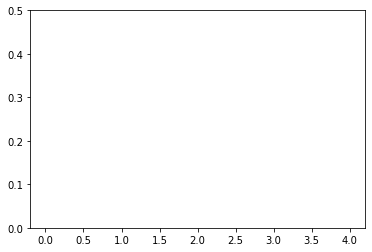

In [13]:
print('train on ',d_type)
loss_history = train(5)  

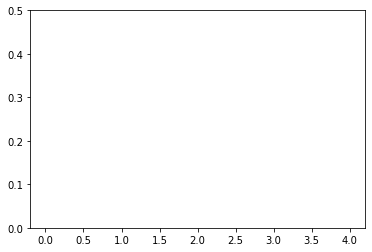

In [14]:
drawLoss(loss_history)